# 第3章 Spark上数据的获取、 处理与准备

环境准备:

In [1]:
# NumPy/Matplotlib
from matplotlib import pyplot as plt
import numpy as np

# PySpark
from pyspark import SparkConf, SparkContext
conf = SparkConf().setMaster('local').setAppName('Demo')
sc = SparkContext(conf=conf)
sc

<SparkContext master=local appName=Demo>

## 3.1 获取公开数据集
本章使用MovieLens数据。

MovieLens 100k数据集包含表示多个用户对多部电影的10万次评级数据，也包含电影元数据和用户属性信息：
+ u.user: 用户属性文件，包含user.id、age、gender、occupation和ZIP code属性，各属性之间用管道符|分隔
+ u.item: 电影元数据，包含movie id、title、release date以及若干与IMDB link和电影分类相关的属性，各个属性之间也用|符号分隔
+ u.data: 用户对电影的评级，包含user id、movie id、rating（从1到5）和timestamp属性，各属性用制表符分隔

## 3.2 探索和可视化数据
分别分析上述三个文件包含的数据。

### 3.2.1 探索用户数据
首先来分析MovieLens用户的特征。

In [2]:
user_data = sc.textFile("./ml-100k/u.user")
user_data.first()

'1|24|M|technician|85711'

In [3]:
user_fields = user_data.map(lambda line: line.split("|")) 
num_users = user_fields.map(lambda fields: fields[0]).count() 
num_genders = user_fields.map(lambda fields: fields[2]).distinct().count() 
num_occupations = user_fields.map(lambda fields: fields[3]).distinct().count() 
num_zipcodes = user_fields.map(lambda fields: fields[4]).distinct().count() 
print("Users: %d, genders: %d, occupations: %d, ZIP codes: %d" 
      % (num_users, num_genders, num_occupations, num_zipcodes))

Users: 943, genders: 2, occupations: 21, ZIP codes: 795


绘制用户年龄的直方图： 

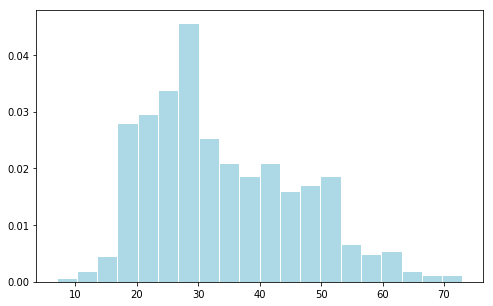

In [4]:
ages = user_fields.map(lambda x: int(x[1])).collect() 
plt.hist(ages, bins=20, color='lightblue', edgecolor='white', normed=True) 
fig = plt.gcf() 
fig.set_size_inches(8, 5)
plt.show()

从上图中可以看出MovieLens的用户偏年轻，大量用户处于15岁到35岁之间。

显示用户的职业分布：

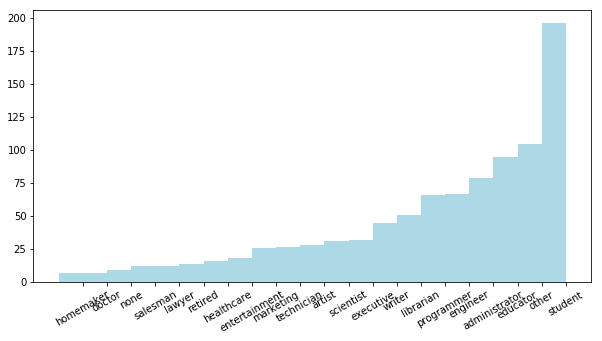

In [5]:
count_by_occupation = user_fields.map(lambda fields: (fields[3], 1)).reduceByKey(lambda x, y: x + y).collect() 

x_axis1 = np.array([c[0] for c in count_by_occupation]) 
y_axis1 = np.array([c[1] for c in count_by_occupation])

x_axis = x_axis1[np.argsort(y_axis1)]
y_axis = y_axis1[np.argsort(y_axis1)]

pos = np.arange(len(x_axis))
width = 1.0

ax = plt.axes()
ax.set_xticks(pos + (width / 2))
ax.set_xticklabels(x_axis)

plt.bar(pos, y_axis, width, color='lightblue')
plt.xticks(rotation=30)
fig1 = plt.gcf()
fig1.set_size_inches(10, 5)
plt.show()

Spark对RDD提供了一个名为countByValue的便捷函数。它会计算RDD里各不同值所分别出现的次数，并将其以Python dict函数的形式返回给驱动程序，功能和上面的代码一样：

In [6]:
count_by_occupation2 = user_fields.map(lambda fields: fields[3]).countByValue() 
print("Map-reduce approach:")
print(dict(count_by_occupation2))
print("")
print("countByValue approach:")
print(dict(count_by_occupation))

Map-reduce approach:
{'engineer': 67, 'librarian': 51, 'executive': 32, 'other': 105, 'student': 196, 'healthcare': 16, 'marketing': 26, 'technician': 27, 'scientist': 31, 'entertainment': 18, 'none': 9, 'lawyer': 12, 'doctor': 7, 'retired': 14, 'administrator': 79, 'educator': 95, 'salesman': 12, 'programmer': 66, 'writer': 45, 'artist': 28, 'homemaker': 7}

countByValue approach:
{'none': 9, 'engineer': 67, 'librarian': 51, 'executive': 32, 'other': 105, 'administrator': 79, 'educator': 95, 'student': 196, 'healthcare': 16, 'artist': 28, 'retired': 14, 'marketing': 26, 'doctor': 7, 'technician': 27, 'scientist': 31, 'lawyer': 12, 'writer': 45, 'entertainment': 18, 'programmer': 66, 'salesman': 12, 'homemaker': 7}


### 3.2.2 探索电影数据
接下来了解下电影分类数据的特征。

In [7]:
movie_data = sc.textFile("./ml-100k/u.item")
movie_data.first()

'1|Toy Story (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)|0|0|0|1|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0'

In [8]:
num_movies = movie_data.count()
num_movies

1682

绘制电影年龄的分布图(电影年龄即其发行年份相对于现在过了多少年，在本数据中现在是1998年）：

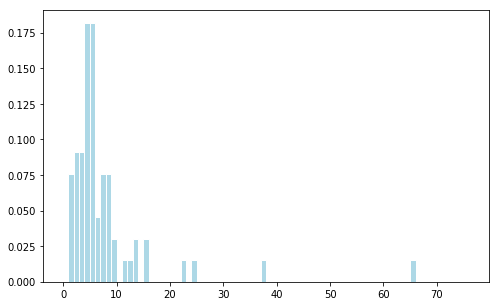

In [9]:
def convert_year(x):
    try:
        return int(x[-4:]) 
    except:
        return 1900 #若数据缺失年份则将其年份设为1900。在后续处理中会过滤掉这类数据

movie_fields = movie_data.map(lambda lines: lines.split("|")) 
years = movie_fields.map(lambda fields: fields[2]).map(lambda x: convert_year(x))
# we filter out any 'bad' data points here
years_filtered = years.filter(lambda x: x != 1900)
# plot the movie ages histogram
movie_ages = years_filtered.map(lambda yr: 1998-yr).countByValue()
values = movie_ages.values()
bins = list(movie_ages.keys())
plt.hist(values, bins=bins, color='lightblue', edgecolor='white', normed=True)
fig = plt.gcf()
fig.set_size_inches(8,5)
plt.show()

### 3.2.3 探索评级数据
现在来看一下评级数据：

In [10]:
rating_data_raw = sc.textFile("./ml-100k/u.data")
print(rating_data_raw.first())

196	242	3	881250949


In [11]:
num_ratings = rating_data_raw.count()
print("Ratings: %d" % num_ratings)

Ratings: 100000


In [12]:
rating_data = rating_data_raw.map(lambda line: line.split("\t"))
ratings = rating_data.map(lambda fields: int(fields[2]))
max_rating = ratings.reduce(lambda x, y: max(x, y))
min_rating = ratings.reduce(lambda x, y: min(x, y))
mean_rating = ratings.reduce(lambda x, y: x + y) / float(num_ratings)
median_rating = np.median(ratings.collect())
ratings_per_user = num_ratings / num_users
ratings_per_movie = num_ratings / num_movies
print("Min rating: %d" % min_rating)
print("Max rating: %d" % max_rating)
print("Average rating: %2.2f" % mean_rating)
print("Median rating: %d" % median_rating)
print("Average # of ratings per user: %2.2f" % ratings_per_user)
print("Average # of ratings per movie: %2.2f" % ratings_per_movie)

Min rating: 1
Max rating: 5
Average rating: 3.53
Median rating: 4
Average # of ratings per user: 106.04
Average # of ratings per movie: 59.45


Spark对RDD也提供一个名为states的函数，该函数包含一个数值变量用于做类似的统计：

In [13]:
ratings.stats()

(count: 100000, mean: 3.529859999999947, stdev: 1.12566797076, max: 5.0, min: 1.0)

评分值分布的条形图：

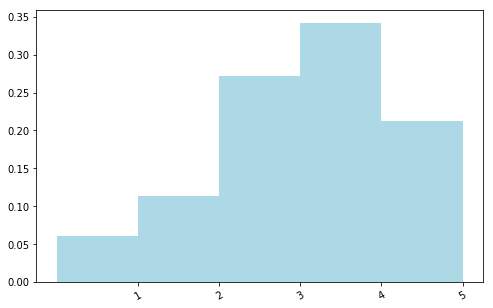

In [14]:
count_by_rating = ratings.countByValue()
x_axis = np.array(list(count_by_rating.keys()))
y_axis = np.array([float(c) for c in count_by_rating.values()])
# we normalize the y-axis here to percentages
y_axis_normed = y_axis / y_axis.sum()

pos = np.arange(len(x_axis))
width = 1.0

ax = plt.axes()
ax.set_xticks(pos + (width / 2))
ax.set_xticklabels(x_axis)

plt.bar(pos, y_axis_normed, width, color='lightblue')
plt.xticks(rotation=30)
fig2 = plt.gcf()
fig2.set_size_inches(8, 5)
plt.show()

绘制用户评分次数的条形图，观察图形可以看出，大部分用户的评级次数少于100，但也表明仍然有较多用户做出过上百次的评级： 

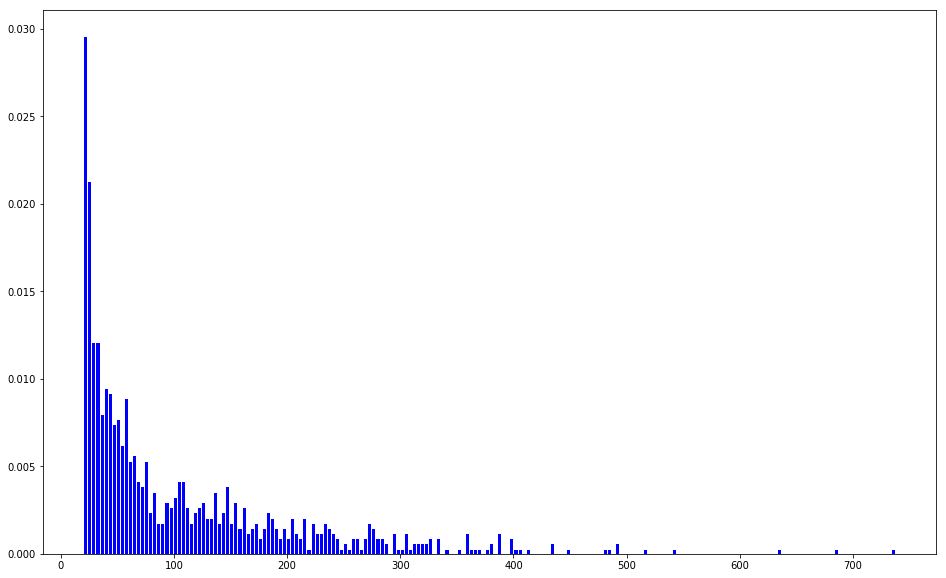

In [15]:
# to compute the distribution of ratings per user, we first group the ratings by user id
user_ratings_grouped = rating_data.map(lambda fields: (int(fields[0]), int(fields[2]))).groupByKey() 
# fix: user_ratings_byuser = user_ratings_grouped.map(lambda (k, v): (k, len(v)))
user_ratings_byuser = user_ratings_grouped.mapValues(lambda x: len(x))
user_ratings_byuser.take(5)

# user_ratings_byuser_local = user_ratings_byuser.map(lambda (k, v): v).collect()
user_ratings_byuser_local = user_ratings_byuser.values().collect()
plt.hist(user_ratings_byuser_local, bins=200, color='blue', edgecolor='white', normed=True)
fig3 = plt.gcf()
fig3.set_size_inches(16,10)
plt.show()

### 3.3 处理与转换数据
为让原始数据可用于机器学习算法，需要先对其进行清理，并可能需要将其进行各种转换，之后才能从转换后的数据里提取有用的特征。数据的转换和特征提取联系紧密。某些情况下，一些转换本身便是特征提取的过程。数据处理和转换的方法如下：
+ 过滤掉或删除非规整或有值缺失的数据：这通常是必须的，但的确会损失这些数据里那些好的信息
+ 填充非规整或缺失的数据：可以根据其他的数据来填充非规整或缺失的数据。方法包括用零值、全局期望或中值来填充，或是根据相邻或类似的数据点来做插值（通常针对时序数据）等。选择正确的方式并不容易，它会因数据、应用场景和个人经验而不同
+ 对异常值做鲁棒处理：异常值的主要问题在于即使它们是极值也不一定就是错的。到底是对是错通常很难分辨。异常值可被移除或是填充，但的确存在某些统计技术（如鲁棒回归）可用于处理异常值或是极值
+ 对可能的异常值进行转换：另一种处理异常值或极值的方法是进行转换。对那些可能存在异常值或值域覆盖过大的特征，利用如对数或高斯核对其转换。这类转换有助于降低变量存在的值跳跃的影响，并将非线性关系变为线性的

下面的代码对发行日期有问题的数据采取了填充策略，即用发行日期的中位数来填充问题数据

In [16]:
years_pre_processed = movie_fields.map(lambda fields: fields[2]).map(lambda x: convert_year(x)).collect()
years_pre_processed_array = np.array(years_pre_processed)

mean_year = np.mean(years_pre_processed_array[years_pre_processed_array!=1900]) 
median_year = np.median(years_pre_processed_array[years_pre_processed_array!=1900]) 
index_bad_data = np.where(years_pre_processed_array==1900)[0][0]
years_pre_processed_array[index_bad_data] = median_year

print("Mean year of release: %d" % mean_year)
print("Median year of release: %d" % median_year)
print("Index of '1900' after assigning median: %s" % np.where(years_pre_processed_array == 1900)[0])

Mean year of release: 1989
Median year of release: 1995
Index of '1900' after assigning median: []


## 3.4 从数据中提取有用特征
在完成对数据的初步探索、处理和清理后，便可从中提取可供机器学习模型训练用的特征。

特征（feature）指那些用于模型训练的变量。每一行数据包含可供提取到训练样本中的各种信息。从根本上说，几乎所有机器学习模型都是与用向量表示的数值特征打交道；因此，我们需要将原始数据转换为数值。

特征可以概括地分为如下几种。
+ 数值特征（numerical feature）：这些特征通常为实数或整数，比如之前例子中提到的年龄
+ 类别特征（categorical feature）：它们的取值只能是可能状态集合中的某一种。我们数据集中的用户性别、职业或电影类别便是这类
+ 文本特征（text feature）：它们派生自数据中的文本内容，比如电影名、描述或是评论
+ 其他特征：大部分其他特征都最终表示为数值。比如图像、视频和音频可被表示为数值数据的集合。地理位置则可由经纬度或地理散列（geohash）表示

### 3.4.1 数值特征
原始的数值和一个数值特征之间的区别是什么？实际上，任何数值数据都能作为输入变量。但是，机器学习模型中所学习的是各个特征所对应的向量的权值。这些权值在特征值到输出或是目标变量（指在监督学习模型中）的映射过程中扮演重要角色。

### 3.4.2 类别特征
当类别特征仍为原始形式时，其取值来自所有可能取值所构成的集合而不是一个数字，故不能作为输入。这样的类别特征也称作名义（nominal）变量，即其各个可能取值之间没有顺序关系。相反，那些存在顺序关系的（比如从定义上说评级5会高于或是好于评级1）则被称为有序（ordinal）变量。

将名义变量表示为可用于机器学习任务的形式，会需要借助如$1-of-k$编码这样的方法。有序变量的原始值可能就能直接使用，但也常会经过和名义变量一样的编码处理。

假设变量可取的值有$k$个。如果对这些值用$1$到$k$编序，则可以用长度为$k$的二元向量来表示一个变量的取值。在这个向量里，该取值对应的序号所在的元素为$1$，其他元素都为$0$。

In [17]:
all_occupations = user_fields.map(lambda fields: fields[3]).distinct().collect()
all_occupations.sort()

idx = 0 
all_occupations_dict = {} 
for o in all_occupations:
    all_occupations_dict[o] = idx
    idx +=1

print("Encoding of 'doctor': %d" % all_occupations_dict['doctor'])
print("Encoding of 'programmer': %d" % all_occupations_dict['programmer'])

K = len(all_occupations_dict) 
binary_x = np.zeros(K) 
k_programmer = all_occupations_dict['programmer'] 
binary_x[k_programmer] = 1 

print("Binary feature vector: %s" % binary_x)
print("Length of binary vector: %d" % K)

Encoding of 'doctor': 2
Encoding of 'programmer': 14
Binary feature vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
  0.  0.  0.]
Length of binary vector: 21


### 3.4.3 派生特征
从现有的一个或多个变量派生出新的特征常常是有帮助的。理想情况下，派生出的特征能比原始属性带来更多信息。比如，可以分别计算各用户已有的电影评级的平均数。这将能给模型加入针对不同用户的个性化特征（事实上，这常用于推荐系统）。

从原始数据派生特征的例子包括计算平均值、中位值、方差、和、差、最大值或最小值以及计数。

数值特征到类别特征的转换也很常见，比如划分为区间特征。进行这类转换的变量常见的有年龄、地理位置和时间。

例如，我们将时间戳变量转为点钟数，再接着转为了时间段，从而得到了一个类别特征：

In [26]:
def extract_datetime(ts):
    import datetime 
    return datetime.datetime.fromtimestamp(ts)

# 提取小时数据
timestamps = rating_data.map(lambda fields: int(fields[3])) 
hour_of_day = timestamps.map(lambda ts: extract_datetime(ts).hour)
hour_of_day.take(5)

def assign_tod(hr):
    times_of_day={
        'moring':range(7,12),
        'lunch':range(12,14),
        'afternon':range(14,18),
        "evening":range(18,23),
        "night":[23,24,1,2,3,4,5,6]
    }
    for k, v in times_of_day.items():
        if hr in v:
            return k

time_of_day = hour_of_day.map(lambda hr: assign_tod(hr)) 
time_of_day.take(5)

['night', 'night', 'afternon', 'lunch', 'lunch']

### 3.4.4 文本特征
从某种意义上说，文本特征也是一种类别特征或派生特征。文本的处理方式有很多种。自然语言处理便是专注于文本内容的处理、表示和建模的一个领域。关于文本处理的完整内容并不在本书的讨论范围内，但我们会介绍一种简单且标准化的文本特征提取方法。该方法被称为词袋（bag-of-word）表示法。

词袋法将一段文本视为由其中的文本或数字组成的集合，其处理过程如下：
+ 分词（tokenization）：首先会应用某些分词方法来将文本分隔为一个由词（一般如单词、数字等）组成的集合。可用的方法如空白分隔法。这种方法在空白处对文本分隔并可能还删除其他如标点符号和其他非字母或数字字符
+ 删除停用词（stop words removal）：之后，它通常会删除常见的单词，比如the、and和but
+ 提取词干（stemming）：下一步则是词干的提取。这是指将各个词简化为其基本的形式或者干词。常见的例子如复数变为单数（比如dogs变为dog等）。提取的方法有很多种，文本处理算法库中常常会包括多种词干提取方法
+ 向量化（vectorization）：最后一步就是用向量来表示处理好的词。二元向量可能是最为简单的表示方式。它用1和0来分别表示是否存在某个词。从根本上说，这与之前提到的$1-of-k$编码相同。它需要一个词的字典来实现词到索引序号的映射。随着遇到的词增多，各种词可能达数百万。由此，使用稀疏矩阵来表示就很关键。这种表示只记录某个词是否出现过，从而节省内存和磁盘空间，以及计算时间

下面的代码提取电影名的文本特征：

In [38]:
def extract_title(raw):
    import re 
    # 该表达式找寻括号之间的非单词(数字)
    grps = re.search("\((\w+)\)", raw) 
    if grps:
        # 只选取标题部分，并删除末尾的空白字符
        return raw[:grps.start()].strip()
    else:
        return raw

# raw_titles = movie_fields.map(lambda fields: fields[1])
# for raw_title in raw_titles.take(5):
#     print(extract_title(raw_title))

movie_titles = raw_titles.map(lambda m: extract_title(m)) 

# 下面用简单空白分词法将标题分词为词 
title_terms = movie_titles.map(lambda t: t.split(" ")) 

# 下面取回所有可能的词，以便构建一个词到序号的映射字典 
all_terms = title_terms.flatMap(lambda x: x).distinct().collect() 

# 创建一个新的字典来保存词，并分配k之1序号 
idx = 0 
all_terms_dict = {}

for term in all_terms:
    all_terms_dict[term] = idx 
    idx += 1

print("Total number of terms: %d" % len(all_terms_dict))
print("Index of term 'Dead': %d" % all_terms_dict['Dead'])
print("Index of term 'Rooms': %d" % all_terms_dict['Rooms'])

all_terms_dict2 = title_terms.flatMap(lambda x: x).distinct().zipWithIndex().collectAsMap() 
print("Index of term 'Dead': %d" % all_terms_dict2['Dead'])
print("Index of term 'Rooms': %d" % all_terms_dict2['Rooms'])

Total number of terms: 2645
Index of term 'Dead': 2176
Index of term 'Rooms': 246
Index of term 'Dead': 2176
Index of term 'Rooms': 246


创建一个函数，该函数将一个词集合转换为一个稀疏向量的表示。注意上面示例代码中用Spark的broadcast函数来创建了一个包含词字典的广播变量。现实场景中该字典可能会极大，故适合使用广播变量：

In [41]:
# 该函数输入一个词列表，并用k之1编码类似的方式将其编码为一个scipy稀疏向量 
def create_vector(terms, term_dict):
    from scipy import sparse as sp 
    num_terms = len(term_dict) 
    x = sp.csc_matrix((1, num_terms)) 
    for t in terms:
        if t in term_dict:
            idx = term_dict[t] 
            x[0, idx] = 1 
    return x

all_terms_bcast = sc.broadcast(all_terms_dict) 
term_vectors = title_terms.map(lambda terms: create_vector(terms, all_terms_bcast.value)) 
term_vectors.take(5)

[<1x2645 sparse matrix of type '<class 'numpy.float64'>'
 	with 2 stored elements in Compressed Sparse Column format>,
 <1x2645 sparse matrix of type '<class 'numpy.float64'>'
 	with 1 stored elements in Compressed Sparse Column format>,
 <1x2645 sparse matrix of type '<class 'numpy.float64'>'
 	with 2 stored elements in Compressed Sparse Column format>,
 <1x2645 sparse matrix of type '<class 'numpy.float64'>'
 	with 2 stored elements in Compressed Sparse Column format>,
 <1x2645 sparse matrix of type '<class 'numpy.float64'>'
 	with 1 stored elements in Compressed Sparse Column format>]

### 3.4.5 正则化特征
在将特征提取为向量形式后，一种常见的预处理方式是将数值数据标准化（normalization）。 其背后的思想是将各个数值特征进行转换，以将它们的值域规范到一个标准区间内。标准化的方法有如下几种。
+ 标准化特征：这实际上是对数据集中的单个特征进行转换。比如减去平均值（特征对齐）或是进行标准的正则转换（以使得该特征的平均值和标准差分别为0和1）
+ 标准化特征向量：这通常是对数据中的某一行的所有特征进行转换，以让转换后的特征向量的长度标准化。也就是缩放向量中的各个特征以使得向量的范数为1（常指一阶或二阶范数）。

下面将用第二种情况举例说明。向量正则化可通过numpy的norm函数来实现。具体来说，先计算一个随机向量的二阶范数，然后让向量中的每一个元素都除该范数，从而得到正则化后的向量：

In [42]:
np.random.seed(42) 
x = np.random.randn(10) 
norm_x_2 = np.linalg.norm(x) 
normalized_x = x / norm_x_2 
print("x:\n%s" % x)
print("2-Norm of x: %2.4f" % norm_x_2)
print("Normalized x:\n%s" % normalized_x)
print("2-Norm of normalized_x: %2.4f" % np.linalg.norm(normalized_x))

x:
[ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337 -0.23413696
  1.57921282  0.76743473 -0.46947439  0.54256004]
2-Norm of x: 2.5908
Normalized x:
[ 0.19172213 -0.05336737  0.24999534  0.58786029 -0.09037871 -0.09037237
  0.60954584  0.29621508 -0.1812081   0.20941776]
2-Norm of normalized_x: 1.0000


**用MLlib正则化特征**

Spark在其MLlib机器学习库中内置了一些函数用于特征的缩放和标准化。它们包括供标准正态变换的StandardScaler，以及提供与上述相同的特征向量正则化的Normalizer：

In [45]:
from pyspark.mllib.feature import Normalizer 
normalizer = Normalizer() 
vector = sc.parallelize([x])
normalized_x_mllib = normalizer.transform(vector).first().toArray()

print("x:\n%s" % x)
print("2-Norm of x: %2.4f" % norm_x_2)
print("Normalized x MLlib:\n%s" % normalized_x_mllib)
print("2-Norm of normalized_x_mllib: %2.4f" % np.linalg. norm(normalized_x_mllib))

x:
[ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337 -0.23413696
  1.57921282  0.76743473 -0.46947439  0.54256004]
2-Norm of x: 2.5908
Normalized x MLlib:
[ 0.19172213 -0.05336737  0.24999534  0.58786029 -0.09037871 -0.09037237
  0.60954584  0.29621508 -0.1812081   0.20941776]
2-Norm of normalized_x_mllib: 1.0000
